In [19]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 125)
pd.set_option('display.max_columns', 125)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tqdm
sns.set()

In [20]:
df = pd.read_csv("выборка_после_обработки.csv")

In [1]:
def stand_and_pca(df):
    # стандартизация повторная

    sk_id = df.SK_ID_CURR.reset_index(drop=True)
    X = df.drop(columns=["SK_ID_CURR", "TARGET"]).reset_index(drop=True)
    y = df.TARGET.reset_index(drop=True)

    arr = []
    for e  in X.columns:
        if len(X[e].unique()) < 4:
            arr.append(e)
        
    X_quant = X.drop(columns=arr)
    X_nomin = X[arr]
    
    from sklearn.preprocessing import StandardScaler
    
    scale = StandardScaler()
    
    X_std = scale.fit_transform(X_quant)
    
    X_std = pd.DataFrame(X_std, columns=X_quant.columns)
    
    X = X_std.join(X_nomin)
    
    
    #pca
    pca = PCA(n_components=2)
    
    df_pca = pd.DataFrame(pca.fit_transform(X), columns=["PC1", "PC2"])
    
    # заджоуним target и id для упрощения в дальнейшем
    if "SK_ID_CURR" not in df_pca.columns:
        df_pca = df_pca.join(sk_id)
        df_pca = df_pca.join(y)
    
    # визуал
    tmp = df_pca
    plt.scatter(tmp[tmp.TARGET == 0].PC1, tmp[tmp.TARGET == 0].PC2, marker=".")
    plt.scatter(tmp[tmp.TARGET == 1].PC1, tmp[tmp.TARGET == 1].PC2, marker=".")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    return df_pca

In [2]:
stand_and_pca(df)

NameError: name 'df' is not defined

In [26]:
#удаляем выбросы
df = df.drop(df[df.AMT_INCOME_TOTAL > (0.5 * 10**6)].index)
df = df.drop(df[df.AMT_CREDIT > ( 20* 10**6)].index)
df.shape

(261051, 40)

,PC1,PC2,SK_ID_CURR,TARGET
0,3.070533,-1.181087,100002.0,1.0
1,1.653091,1.228593,100003.0,0.0
2,0.323881,-0.760824,100004.0,0.0
3,-0.449574,-0.642054,100007.0,0.0
4,0.431574,0.368484,100008.0,0.0
...,...,...,...,...
261046,1.483234,-0.269260,453090.0,0.0
261047,-3.109492,-1.352183,453092.0,0.0
261048,-0.150135,0.155384,453095.0,0.0
261049,1.086700,-1.138516,453096.0,0.0


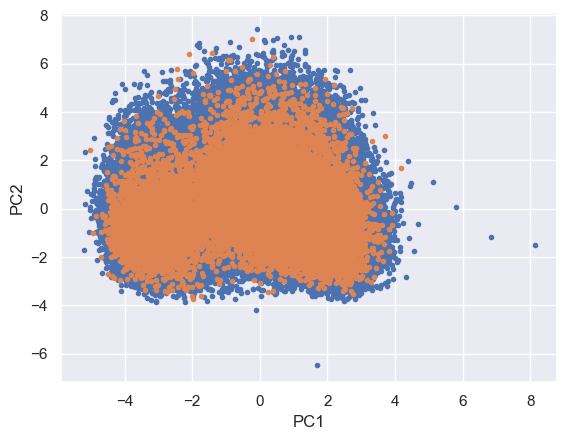

In [27]:
stand_and_pca(df)

In [55]:

def clastorization_score(df):
    
    sk_id = df.SK_ID_CURR
    X = df.drop(columns=["SK_ID_CURR", "TARGET"]).reset_index(drop=True)
    y = df.TARGET

    arr = []
    for e  in X.columns:
        if len(X[e].unique()) < 4:
            arr.append(e)
        
    X_quant = X.drop(columns=arr)
    X_nomin = X[arr]
    
    from sklearn.preprocessing import StandardScaler
    
    scale = StandardScaler()
    
    X_std = scale.fit_transform(X_quant)
    
    X_std = pd.DataFrame(X_std, columns=X_quant.columns)
    
    X = X_std.join(X_nomin)
    
    comp_count = int((len(X.columns) - 1)**0.5)
    
    pca = PCA(n_components=comp_count)
    
    
    
    kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto").fit(pca.fit_transform(X))
    
    X['class']=kmeans.labels_
    
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(X.drop(columns="class"))
    
    ffff=pd.DataFrame(df_pca,columns=['PC1','PC2']).join(X['class']).join(y)
    
    '''for i in ffff['class'].unique():
        plt.scatter(x=ffff[ffff['class']==i].PC1,y=ffff[ffff['class']==i].PC2,label='cluster' + str(i), marker=".")
    plt.scatter(x=ffff[ffff['TARGET']==1].PC1,y=ffff[ffff['TARGET']==1].PC2,label='TARGET', marker=".")
    plt.legend()'''
    
    X["TARGET"] = y
    
    print("Доля объектов с TARGET = 1 внутри кластера")
    for i in X['class'].unique():
        print("Кластер №", i, ":", sep="" ,end=" ")
        print(round(X[X['class']==i].TARGET.value_counts(normalize=True)[1], 3))
    
    print()
    print("Доля объектов с TARGET = 1 от общего колличества объектов с TARGET = 1")
    for i in X['class'].unique():
        print("Кластер №", i, ":", sep="" ,end=" ")
        print(round(X[X['class']==i].TARGET.value_counts()[1] / len(X[X.TARGET == 1]), 3))
        
    print()
    print("Количество объектов с TARGET = 1 внутри кластера")
    for i in X['class'].unique():
        print("Кластер №", i, ":", sep="" ,end=" ")
        print(X[X['class']==i].TARGET.value_counts()[1])
    
    
    
    return X

In [56]:
df_scaled = clastorization_score(df)

Доля объектов с TARGET = 1 внутри кластера
Кластер №4: 0.079
Кластер №2: 0.076
Кластер №0: 0.077
Кластер №1: 0.076
Кластер №3: 0.08

Доля объектов с TARGET = 1 от общего колличества объектов с TARGET = 1
Кластер №4: 0.236
Кластер №2: 0.14
Кластер №0: 0.25
Кластер №1: 0.17
Кластер №3: 0.205

Количество объектов с TARGET = 1 внутри кластера
Кластер №4: 4738
Кластер №2: 2807
Кластер №0: 5022
Кластер №1: 3417
Кластер №3: 4114


<Figure size 640x480 with 0 Axes>

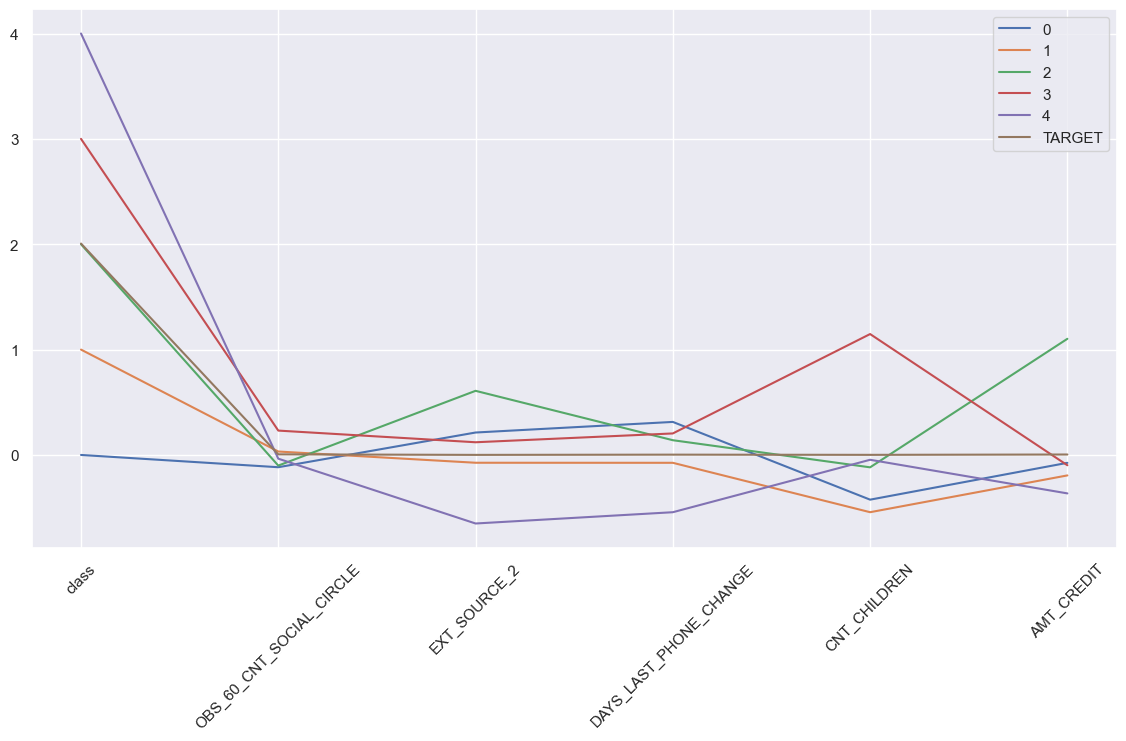

<Figure size 640x480 with 0 Axes>

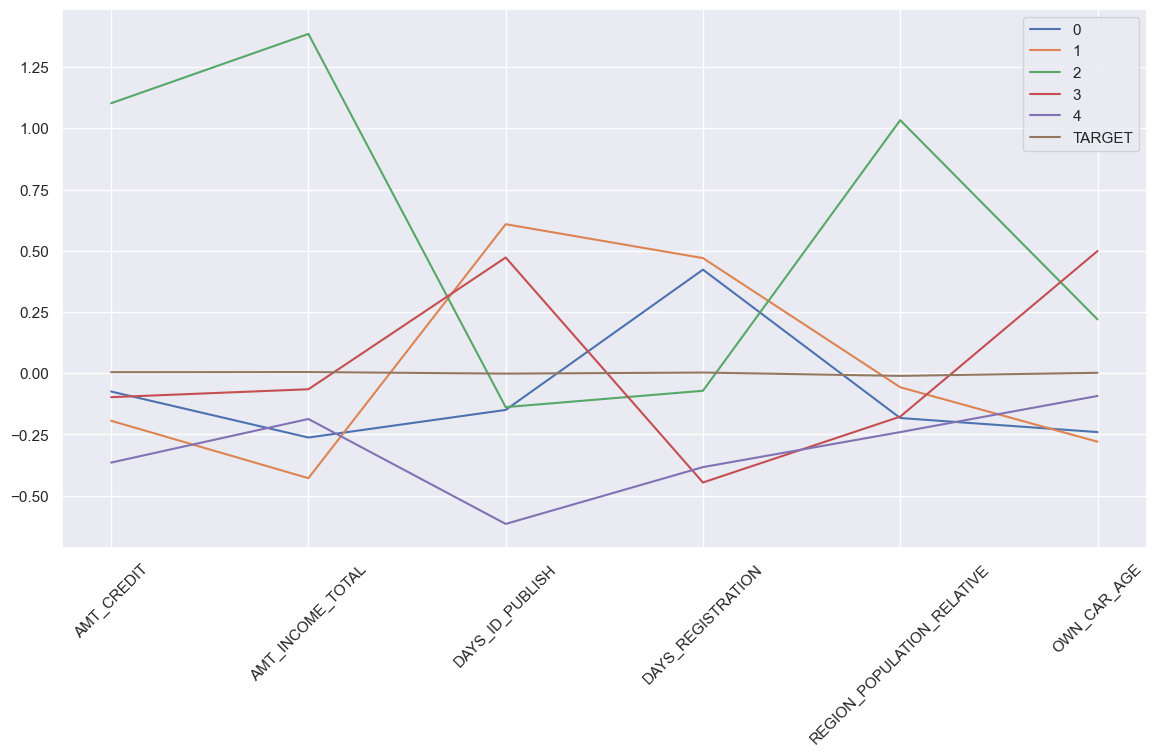

<Figure size 640x480 with 0 Axes>

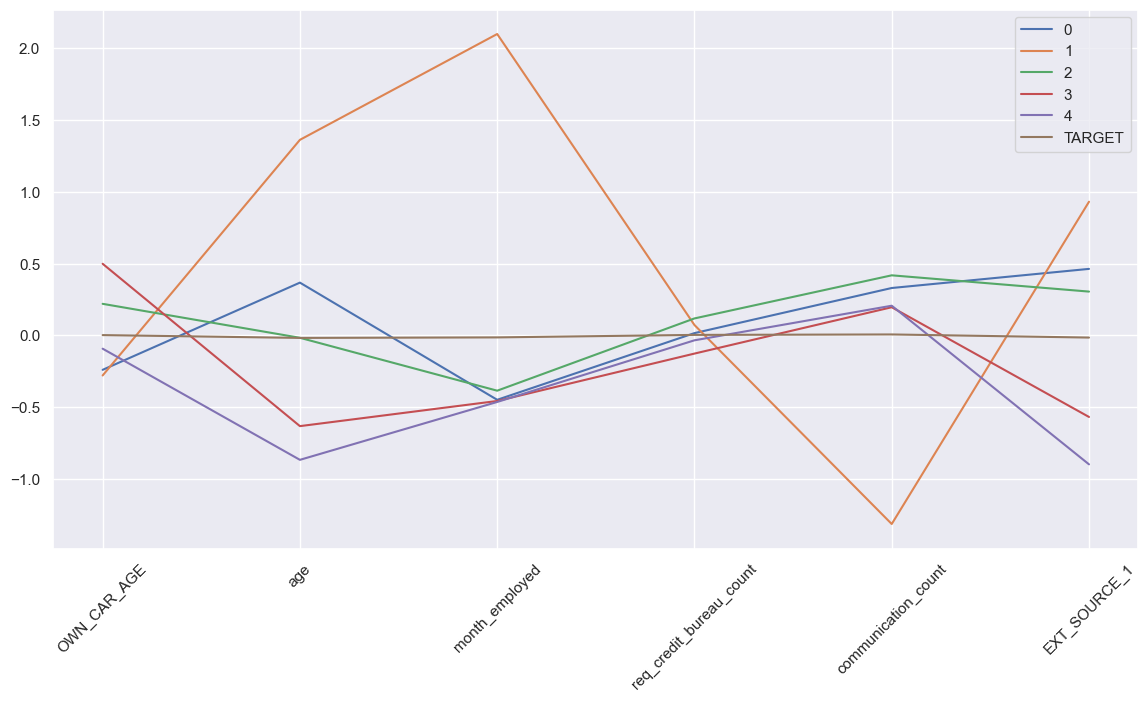

<Figure size 640x480 with 0 Axes>

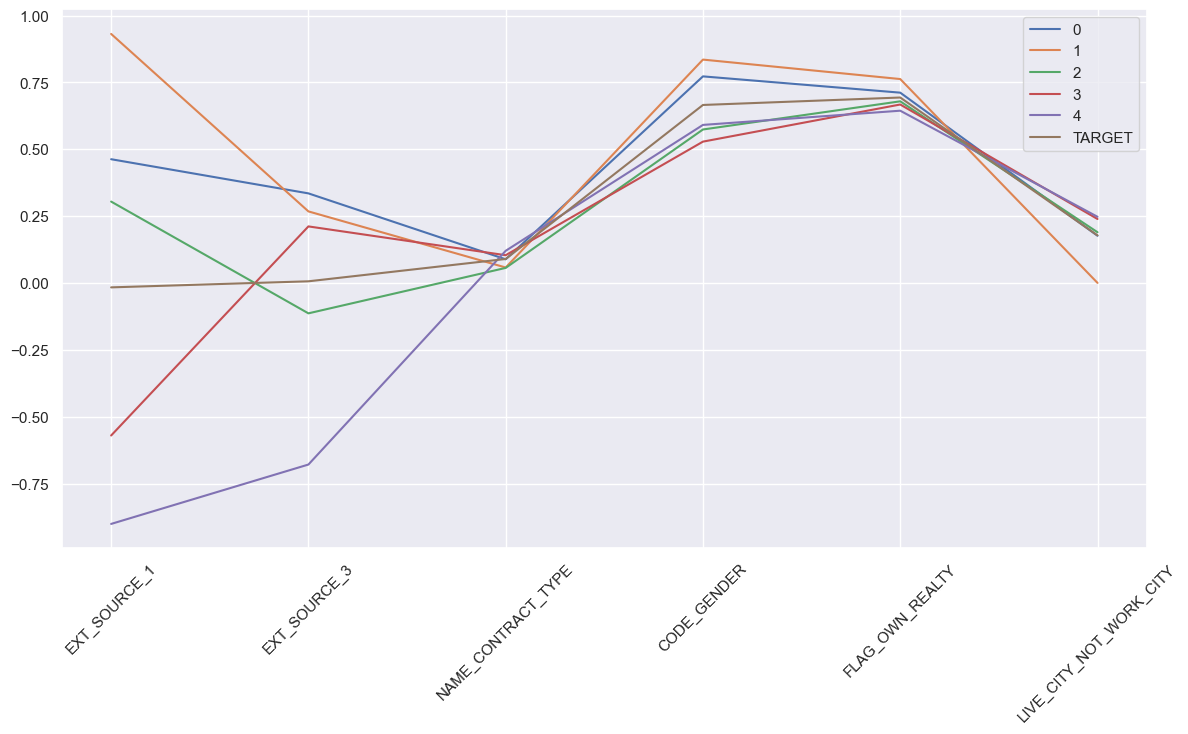

<Figure size 640x480 with 0 Axes>

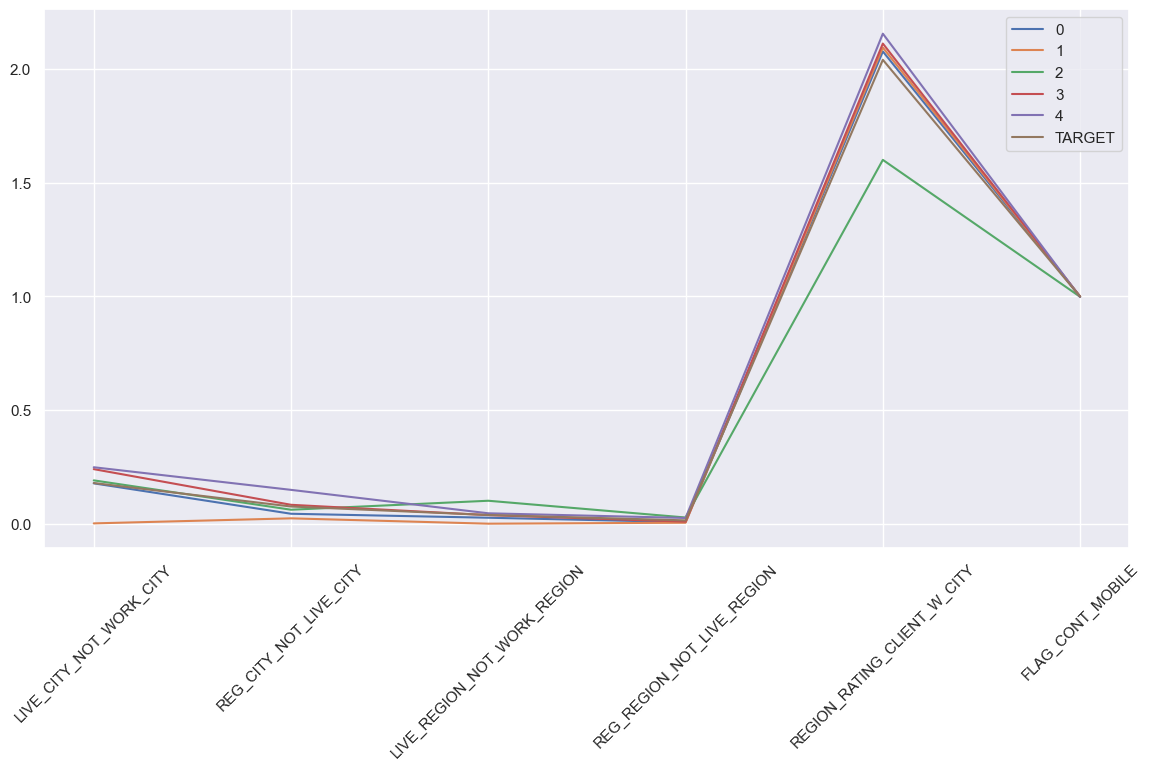

<Figure size 640x480 with 0 Axes>

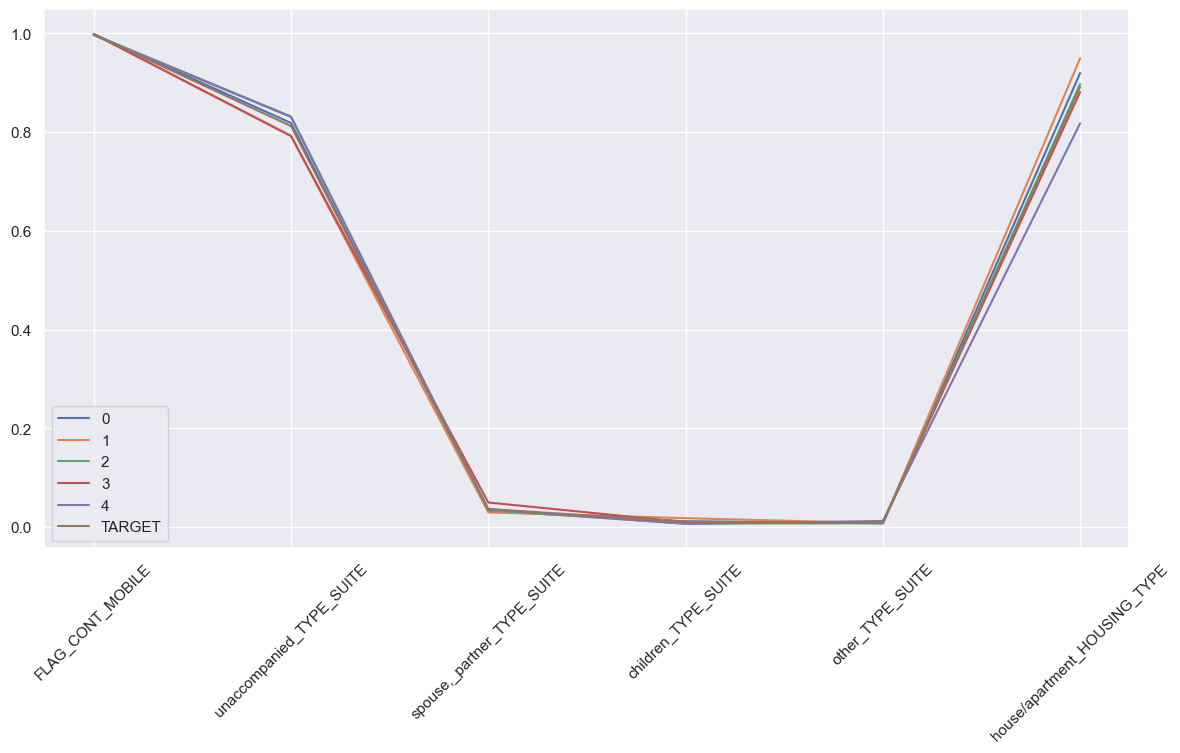

<Figure size 640x480 with 0 Axes>

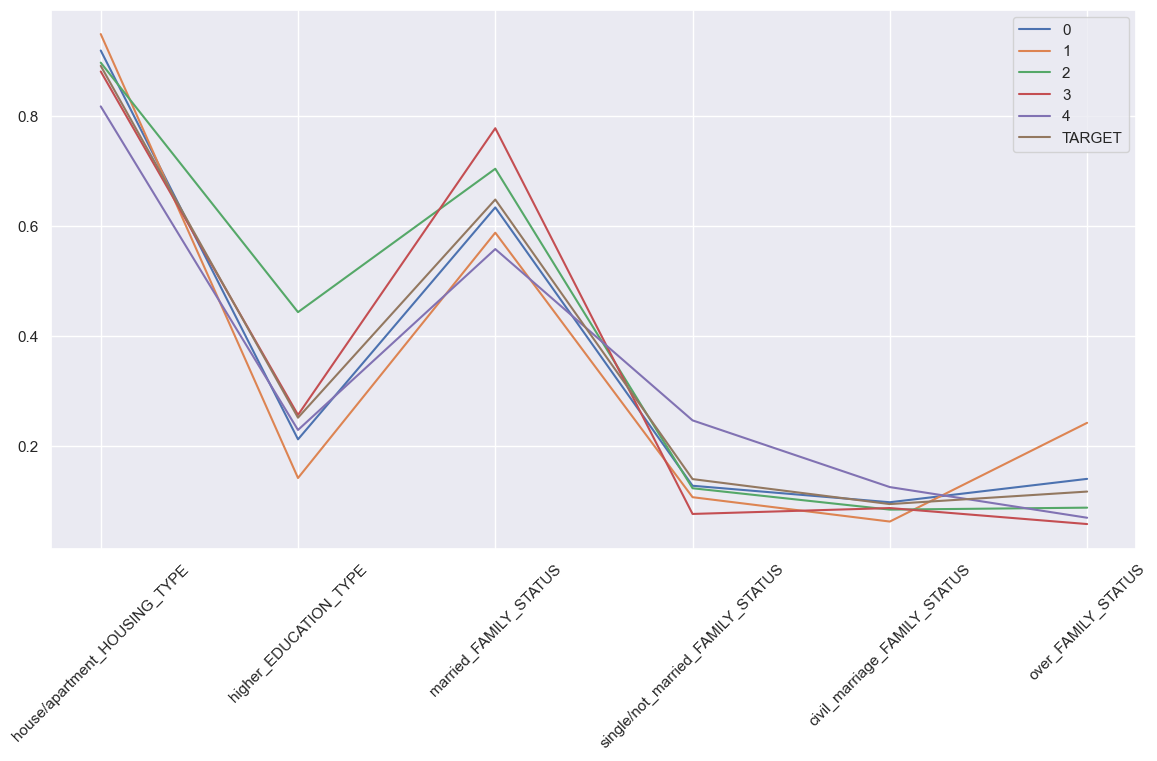

In [57]:

graph = df_scaled.drop(columns='TARGET').groupby(by='class').mean().reset_index().T
graph['TARGET']=df_scaled[df_scaled['TARGET']==1].drop(columns='TARGET').mean().copy()

for i in range(5,graph.shape[0],5):    
    plt.figure()
    graph[i-5:i+1].plot(figsize=[14,7])
    plt.xticks(rotation=45)

In [58]:
# дропаем признаки у которых в разных кластерах и тагете одни и теже средние
print(df.shape)
df.drop(columns= ["NAME_CONTRACT_TYPE", \
                    'LIVE_REGION_NOT_WORK_REGION', \
                  'REG_REGION_NOT_LIVE_REGION', \
                    'FLAG_CONT_MOBILE', \
                     'unaccompanied_TYPE_SUITE', \
                  'spouse,_partner_TYPE_SUITE', \
                  'children_TYPE_SUITE', \
                  'other_TYPE_SUITE'] , inplace=True)
df.shape

(261051, 40)


(261051, 32)

In [59]:
df.columns

Index(['OBS_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE',
       'CNT_CHILDREN', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'AMT_CREDIT',
       'AMT_INCOME_TOTAL', 'LIVE_CITY_NOT_WORK_CITY', 'TARGET',
       'REG_CITY_NOT_LIVE_CITY', 'REGION_RATING_CLIENT_W_CITY',
       'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE',
       'SK_ID_CURR', 'OWN_CAR_AGE', 'age', 'month_employed',
       'req_credit_bureau_count', 'communication_count',
       'house/apartment_HOUSING_TYPE', 'higher_EDUCATION_TYPE',
       'married_FAMILY_STATUS', 'single/not_married_FAMILY_STATUS',
       'civil_marriage_FAMILY_STATUS', 'over_FAMILY_STATUS',
       'working_INCOME_TYPE', 'commercial_associate_INCOME_TYPE',
       'state_servant_INCOME_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3'],
      dtype='object')

In [60]:
df.shape

(261051, 32)

0
0.0    56227
1.0     4801
Name: TARGET, dtype: int64
4
0.0    35666
1.0     2959
Name: TARGET, dtype: int64
2
0.0    57993
1.0     4844
Name: TARGET, dtype: int64
1
0.0    41951
1.0     3443
Name: TARGET, dtype: int64
3
0.0    46768
1.0     4051
Name: TARGET, dtype: int64


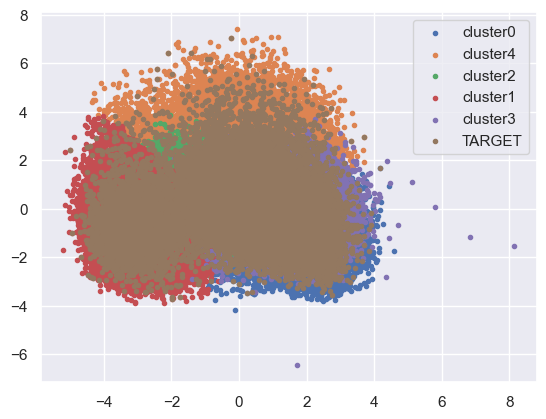

In [15]:
# кластеризация после удаления признаков
df_scaled = clastorization_score(df)

<Figure size 640x480 with 0 Axes>

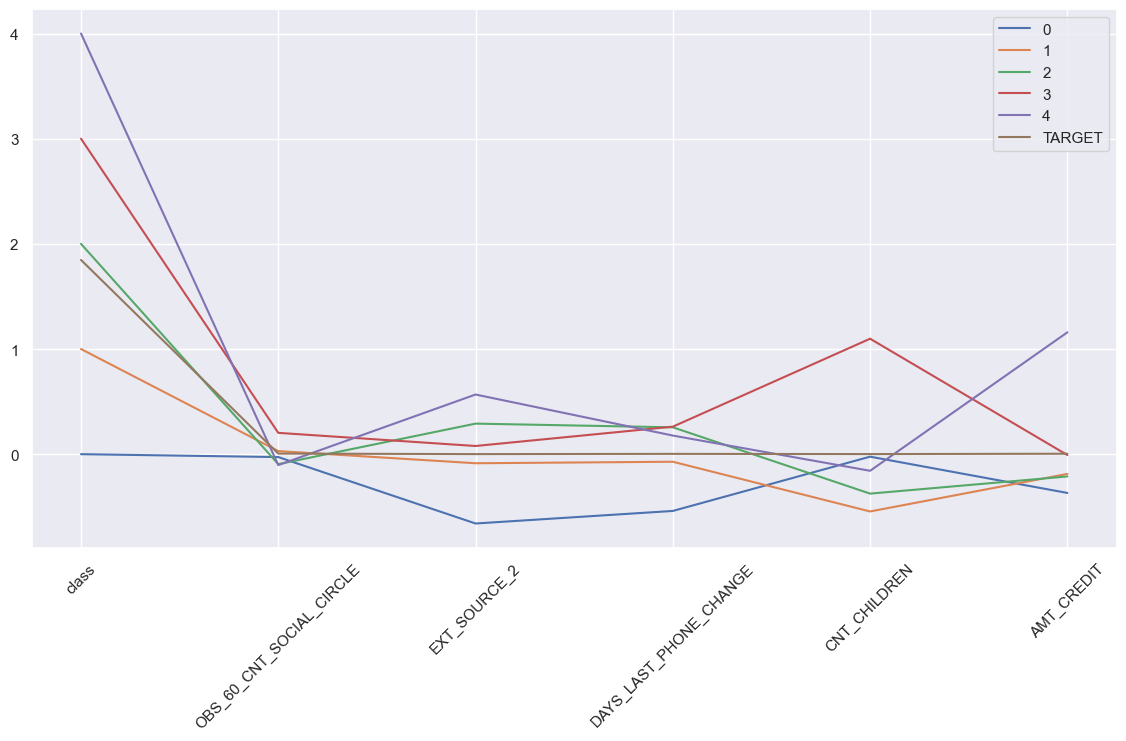

<Figure size 640x480 with 0 Axes>

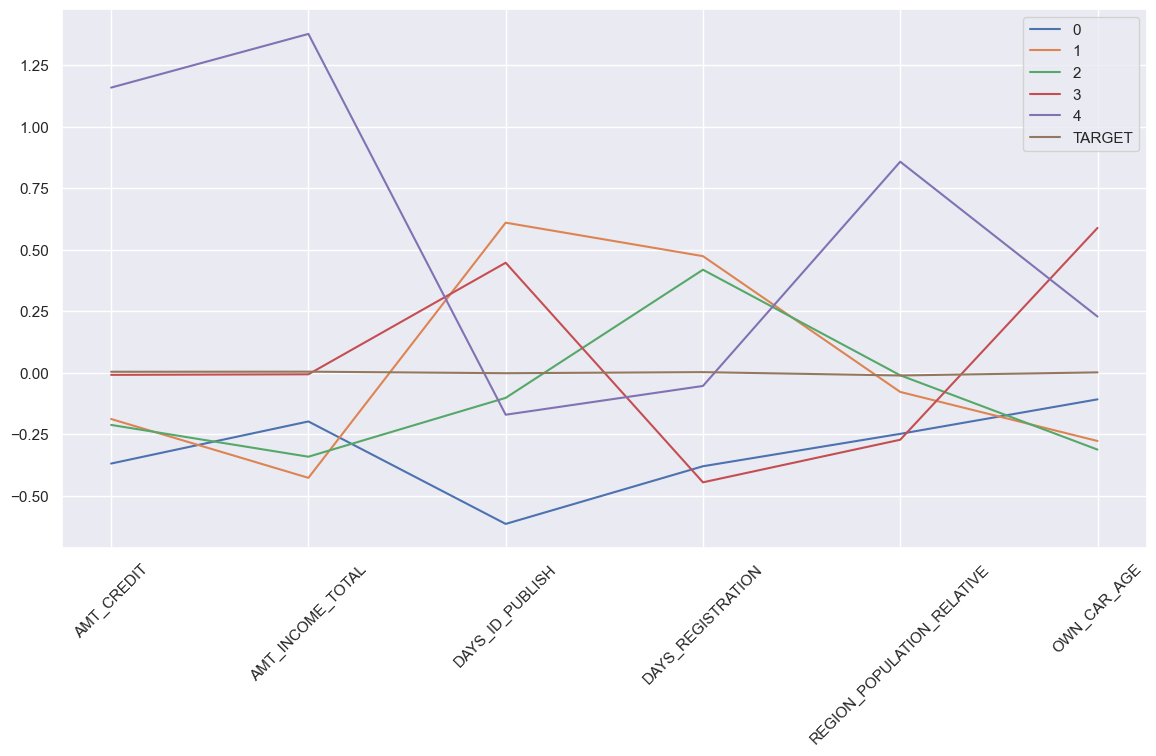

<Figure size 640x480 with 0 Axes>

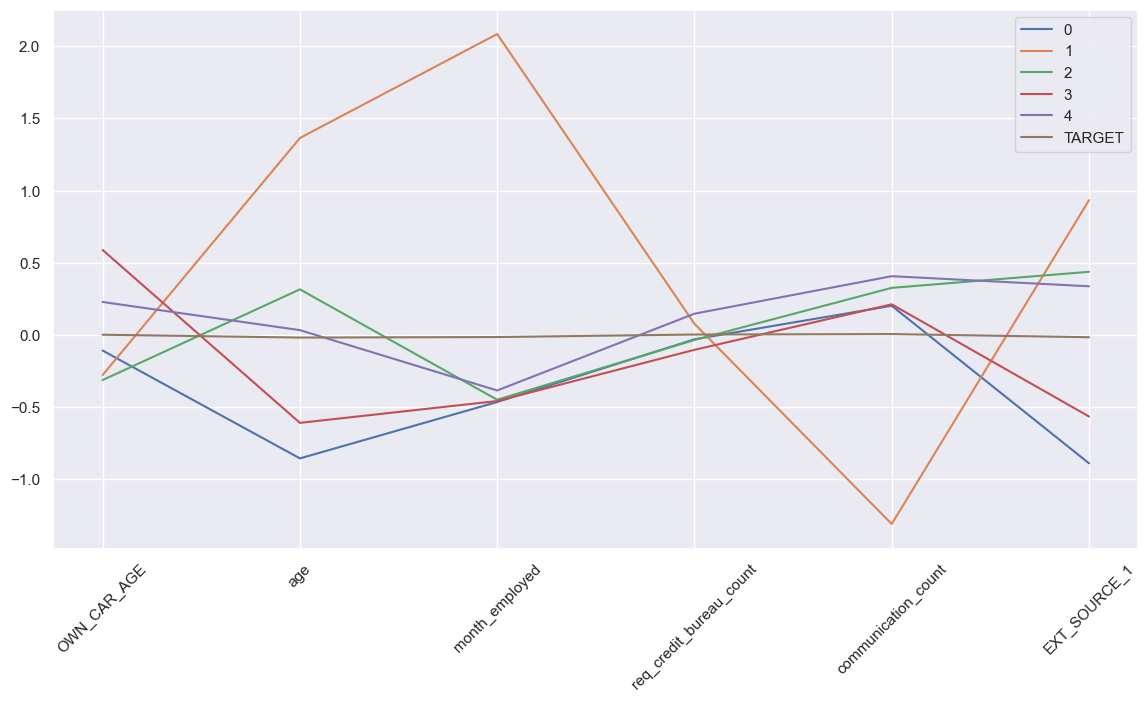

<Figure size 640x480 with 0 Axes>

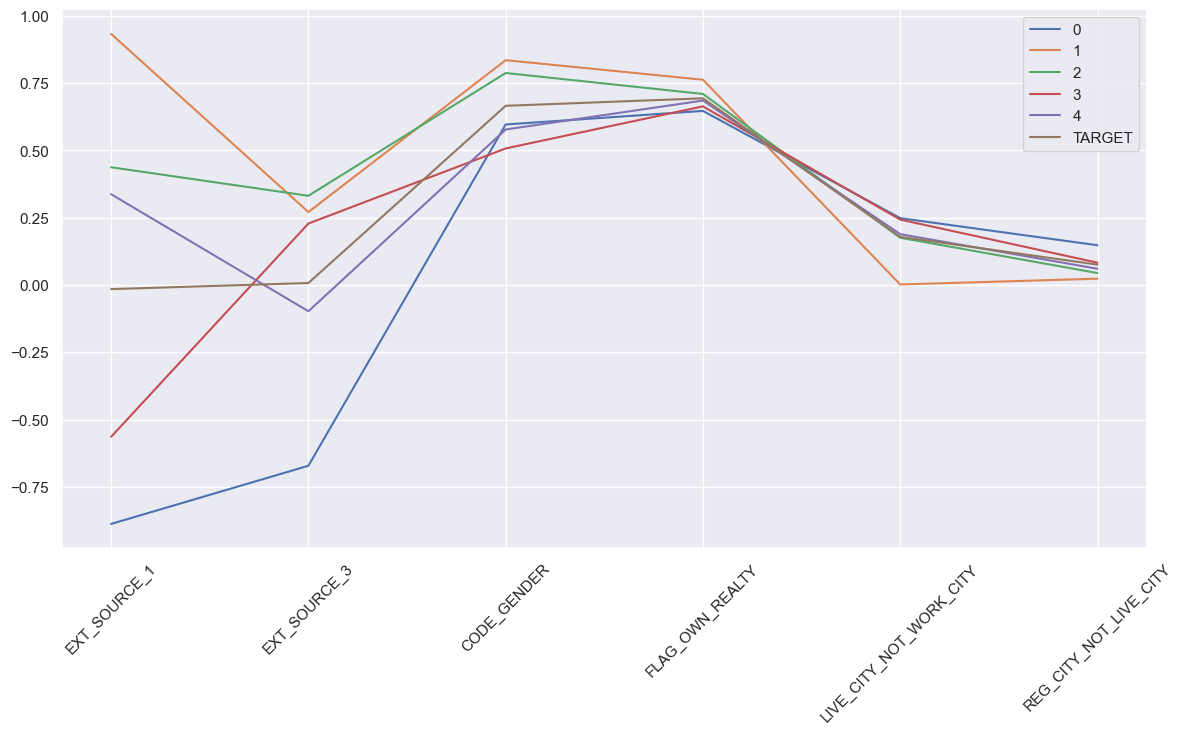

<Figure size 640x480 with 0 Axes>

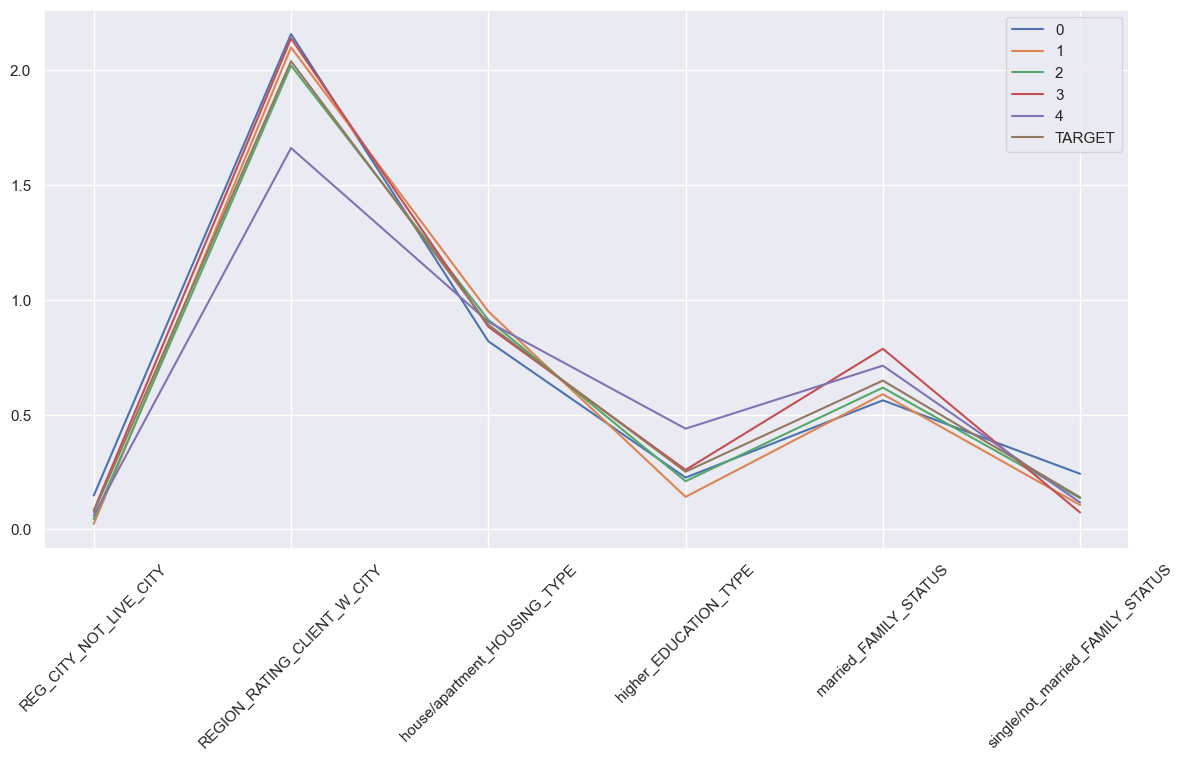

<Figure size 640x480 with 0 Axes>

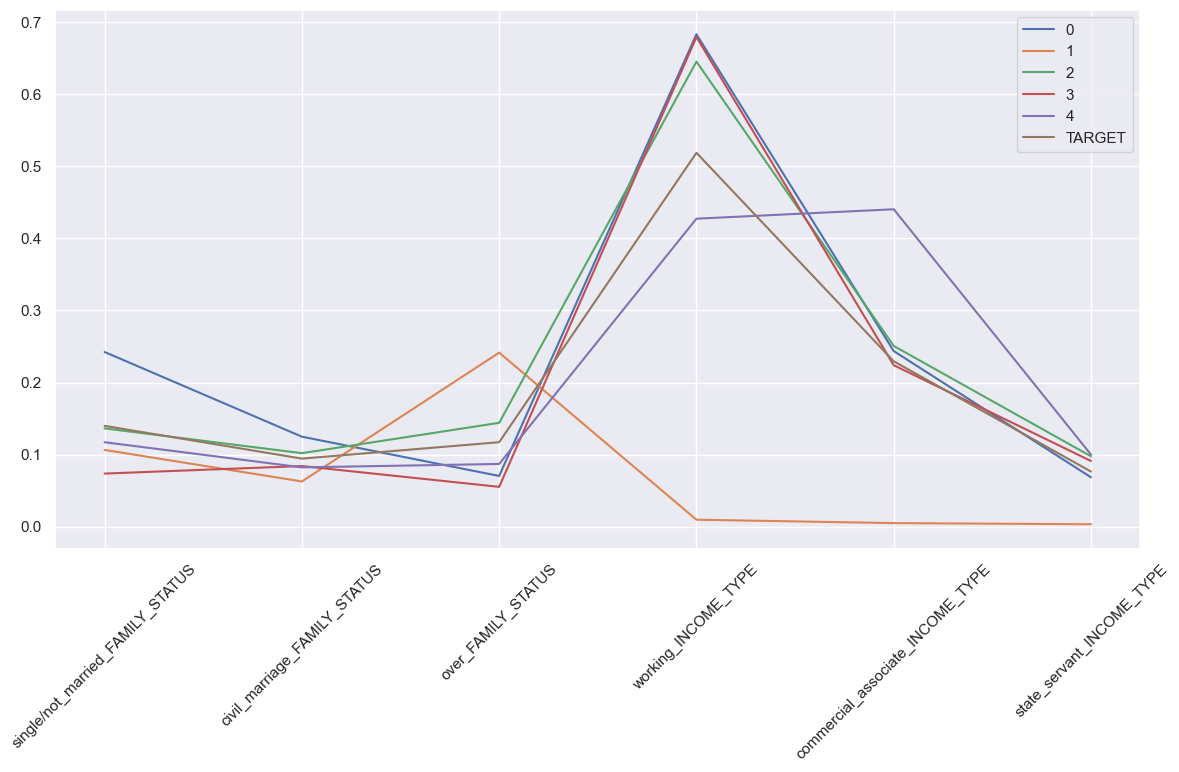

In [16]:
graph = df_scaled.drop(columns='TARGET').groupby(by='class').mean().reset_index().T
graph['TARGET']=df_scaled[df_scaled['TARGET']==1].drop(columns='TARGET').mean().copy()

for i in range(5,graph.shape[0],5):    
    plt.figure()
    graph[i-5:i+1].plot(figsize=[14,7])
    plt.xticks(rotation=45)

In [18]:
df.to_csv('выборка_после_кластеризации.csv', index=False)